# Load Tiny Model

In [1]:
import torch
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from LymphoMNIST.LymphoMNIST import LymphoMNIST
from torchvision import transforms
from torchsummary import summary

In [2]:
class FilteredLymphoMNIST(Dataset):
    def __init__(self, original_dataset, labels_to_keep):
        self.original_dataset = original_dataset
        self.indices = [i for i, (_, label) in enumerate(original_dataset) if label in labels_to_keep]

    def __getitem__(self, index):
        return self.original_dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

def get_dataloaders(train_ds, val_ds, batch_size=64, **kwargs):
    print(f'Loading data with batch size {batch_size}')
    val_size = len(val_ds) // 2
    test_size = len(val_ds) - val_size
    val_ds, test_ds = random_split(val_ds, [val_size, test_size])
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, **kwargs),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs),
    )
    

# Function to calculate accuracy
def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy
    

# Hyperparameters
params = {
    'batch_size': 16,
    'im_size': 48,  # Resize dimension used during training
    'model_checkpoint': "../checkpoint/Final_models/KD_21 October 14_13_resnet50_qt-1channel-no_normalize.pt"  # Path to the saved model
}


import torchvision.transforms as T
transform_student = T.Compose([
    T.Resize((params['im_size'], params['im_size'])),
    T.ToTensor(),
    # T.Normalize([0.4819], [0.1484]),
])

In [3]:
# Initialize datasets
labels_to_keep = [0, 1]
original_train_ds = LymphoMNIST(root='../dataset', train=True, download=True, transform=transform_student, num_classes=3)
original_test_ds = LymphoMNIST(root='../dataset', train=False, download=True, transform=transform_student, num_classes=3)

# Filter datasets
train_ds = FilteredLymphoMNIST(original_train_ds, labels_to_keep)
test_ds = FilteredLymphoMNIST(original_test_ds, labels_to_keep)

# Get dataloaders
# train_dl, val_dl, test_dl = get_dataloaders(train_ds, test_ds, batch_size=params['batch_size'], num_workers=4)

Dataset already exists. Skipping download.
Dataset already exists. Skipping download.


In [4]:
# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class QuantizedCNN(nn.Module):
    def __init__(self, num_classes=2, input_size=(1, 28, 28)):
        super(QuantizedCNN, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self.features(dummy_input)
            num_ftrs = dummy_output.numel() // dummy_output.size(0)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    
# Load saved weights
model = QuantizedCNN(num_classes=2, input_size=(1, params['im_size'], params['im_size'])).to(device)

model.load_state_dict(torch.load(params['model_checkpoint'], map_location=device))

model = model.to(device)


/tmp/ipykernel_47259/619880244.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(params['model_checkpoint'], map_location=device))


In [5]:
from torchsummary import summary
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             160
              ReLU-2           [-1, 16, 46, 46]               0
         MaxPool2d-3           [-1, 16, 23, 23]               0
            Conv2d-4           [-1, 16, 21, 21]           2,320
              ReLU-5           [-1, 16, 21, 21]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
           Flatten-7                 [-1, 1600]               0
           Dropout-8                 [-1, 1600]               0
            Linear-9                    [-1, 2]           3,202
          Softmax-10                    [-1, 2]               0
Total params: 5,682
Trainable params: 5,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.73
Params size (MB): 0.02
Estimated Total

## Latency calculation

In [6]:
from typing import Iterator, Tuple, Any
from collections import defaultdict
import csv
import os
import numpy as np

def calculate_true_latency(
    loader: Iterator[Tuple[torch.Tensor, Any]],
    model: torch.nn.Module,
    device: torch.device,
    num_batches: int = 20,
    warmup_batches: int = 500,
    percentiles: tuple = (50, 90, 95, 99)
) -> dict:
    """
    Calculate true model latency using CUDA events and proper synchronization.
   
    Args:
        loader: DataLoader iterator
        model: PyTorch model
        device: Device to run inference on
        num_batches: Number of batches to measure
        warmup_batches: Number of warmup batches
        percentiles: Tuple of percentiles to calculate
       
    Returns:
        Dictionary containing latency statistics
    """
    model.eval()
    latencies = []
    batch_sizes = []
   
    # Create CUDA events for accurate GPU timing
    # Create CUDA events for accurate GPU timing
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
   
    # Warmup phase
    with torch.no_grad():
        for i, (images, *_) in enumerate(loader):
            if i >= warmup_batches:
                break
            images = images.to(device, non_blocking=True)
            _ = model(images)
   
    # Measurement phase
    with torch.no_grad():
        for i, (images, *_) in enumerate(loader):
            if i >= num_batches:
                break
               
            # Move data to device asynchronously
            images = images.to(device, non_blocking=True)
            
            torch.cuda.synchronize()
            start_event.record()
           
            # Run inference
            _ = model(images)
           

            end_event.record()
            end_event.synchronize()
            latency = start_event.elapsed_time(end_event)

           
            latencies.append(latency)
            batch_sizes.append(images.size(0))
   
    # Convert to numpy for statistics
    latencies = np.array(latencies)
    batch_sizes = np.array(batch_sizes)
    per_image_latencies = latencies / batch_sizes
   
    # Calculate statistics
    stats = {
        'mean_latency_ms_per_batch': float(np.mean(latencies)),
        'std_latency_ms_per_batch': float(np.std(latencies)),
        'mean_latency_ms_per_image': float(np.mean(per_image_latencies)),
        'std_latency_ms_per_image': float(np.std(per_image_latencies)),
        'throughput_imgs_per_sec': float(np.mean(batch_sizes / (latencies / 1000))),
    }
   
    # Add percentiles
    for p in percentiles:
        stats[f'p{p}_latency_ms_per_batch'] = float(np.percentile(latencies, p))
        stats[f'p{p}_latency_ms_per_image'] = float(np.percentile(per_image_latencies, p))
   
    return stats

def run_latency_test(model, test_dl, device, num_batches=20, runs=5, output_csv="latency_results.csv"):
    """Run multiple latency tests, aggregate results, and save them to a CSV file."""
    all_stats = defaultdict(list)

    for run in range(runs):
        print(f"\nRun {run + 1}/{runs}")
        stats = calculate_true_latency(test_dl, model, device, num_batches=num_batches)

        for key, value in stats.items():
            all_stats[key].append(value)

    # Calculate aggregate statistics
    aggregate_stats = {
        key: {
            'mean': float(np.mean(values)),
            'std': float(np.std(values))
        }
        for key, values in all_stats.items()
    }

    print("\n=== Aggregate Results ===")
    print(f"Runs: {runs}")
    print(f"Mean per-image latency: {aggregate_stats['mean_latency_ms_per_image']['mean']:.4f} ms ± {aggregate_stats['mean_latency_ms_per_image']['std']:.4f} ms")
    print(f"Mean per-batch latency: {aggregate_stats['mean_latency_ms_per_batch']['mean']:.4f} ms ± {aggregate_stats['mean_latency_ms_per_batch']['std']:.4f} ms")
    print(f"Mean throughput: {aggregate_stats['throughput_imgs_per_sec']['mean']:.2f} imgs/sec ± {aggregate_stats['throughput_imgs_per_sec']['std']:.2f}")

    # Save results to a CSV file
    csv_exists = os.path.exists(output_csv)
    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write the header only if the file is newly created
        if not csv_exists:
            writer.writerow([
                "Batch Size",
                "Mean Latency per Image (ms)", "Std Latency per Image (ms)",
                "Mean Latency per Batch (ms)", "Std Latency per Batch (ms)",
                "Mean Throughput (imgs/sec)", "Std Throughput (imgs/sec)"
            ])

        # Write the row for the current batch size
        writer.writerow([
            test_dl.batch_size,
            aggregate_stats['mean_latency_ms_per_image']['mean'],
            aggregate_stats['mean_latency_ms_per_image']['std'],
            aggregate_stats['mean_latency_ms_per_batch']['mean'],
            aggregate_stats['mean_latency_ms_per_batch']['std'],
            aggregate_stats['throughput_imgs_per_sec']['mean'],
            aggregate_stats['throughput_imgs_per_sec']['std'],
        ])

    return aggregate_stats


# Example Usage
batch_sizes = [2**i for i in range(0, 20)]  # Powers of 2 from 1 to 1024
output_csv = "latency_results_studen2_final.csv"

# Remove the CSV file if it already exists (optional, for fresh runs)
if os.path.exists(output_csv):
    os.remove(output_csv)

print("\n=== Batch Size Latency and Throughput Testing ===")

# Loop through each batch size and test latency
for batch_size in batch_sizes:
    print(f"\nTesting with batch size: {batch_size}")
    train_dl, val_dl, test_dl = get_dataloaders(train_ds, test_ds, batch_size=batch_size, num_workers=4)
    
    run_latency_test(model, test_dl, device, num_batches=100, runs=5, output_csv=output_csv)

print(f"\nResults saved to {output_csv}")



=== Batch Size Latency and Throughput Testing ===

Testing with batch size: 1
Loading data with batch size 1

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 0.3126 ms ± 0.0068 ms
Mean per-batch latency: 0.3126 ms ± 0.0068 ms
Mean throughput: 3308.58 imgs/sec ± 49.96

Testing with batch size: 2
Loading data with batch size 2

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 0.1751 ms ± 0.0009 ms
Mean per-batch latency: 0.3502 ms ± 0.0019 ms
Mean throughput: 5857.54 imgs/sec ± 31.60

Testing with batch size: 4
Loading data with batch size 4

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 0.0876 ms ± 0.0018 ms
Mean per-batch latency: 0.3504 ms ± 0.0072 ms
Mean throughput: 11768.43 imgs/sec ± 120.14

Testing with batch size: 8
Loading data with batch size 8

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results =

## Plot

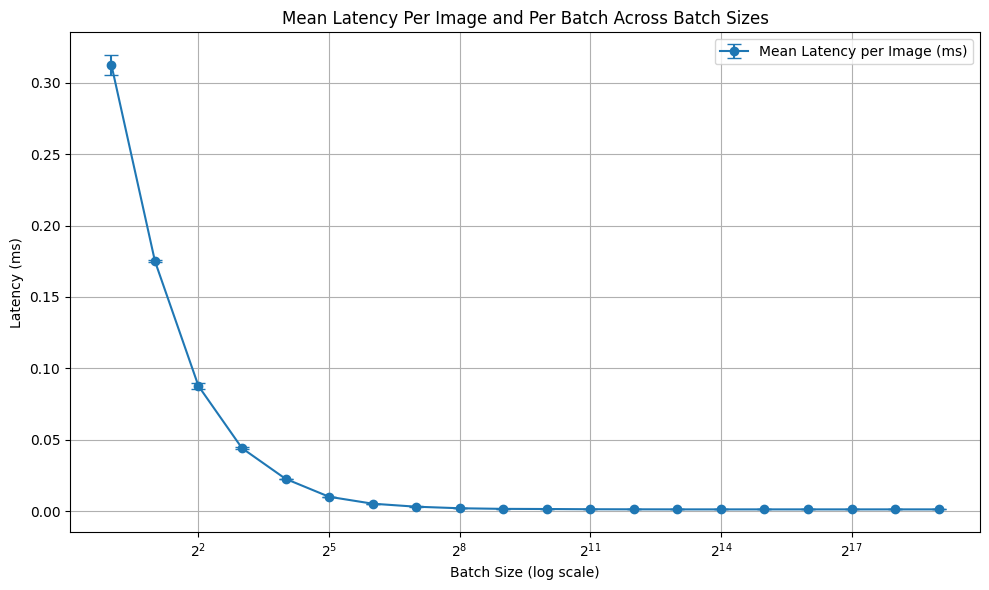

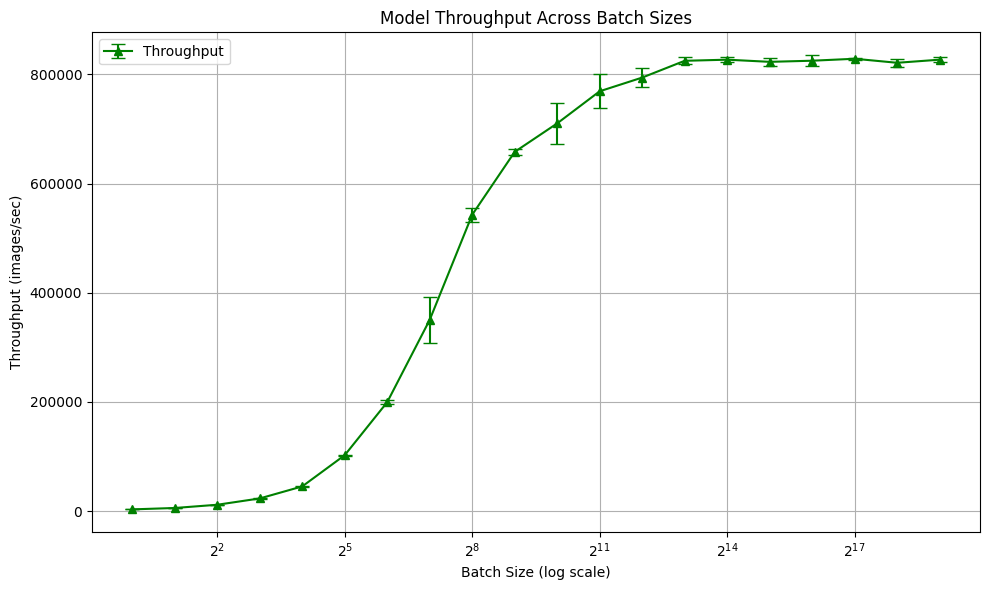

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data into a pandas DataFrame
csv_file = "latency_results_studen2_final.csv"  # Replace with your CSV file name
data = pd.read_csv(csv_file)

# Plot Mean Latency Per Image and Per Batch
plt.figure(figsize=(10, 6))

# Plot mean latency per image
plt.errorbar(
    data["Batch Size"],
    data["Mean Latency per Image (ms)"],
    yerr=data["Std Latency per Image (ms)"],
    fmt='o-',
    label="Mean Latency per Image (ms)",
    capsize=5
)

# Plot mean latency per batch
# plt.errorbar(
#     data["Batch Size"],
#     data["Mean Latency per Batch (ms)"],
#     yerr=data["Std Latency per Batch (ms)"],
#     fmt='s-',
#     label="Mean Latency per Batch (ms)",
#     capsize=5
# )

# Set log scale for x-axis
plt.xscale("log", base=2)

# Add labels, title, and legend
plt.xlabel("Batch Size (log scale)")
plt.ylabel("Latency (ms)")
plt.title("Mean Latency Per Image and Per Batch Across Batch Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()




# Plot Throughput with Error Bars
plt.figure(figsize=(10, 6))
plt.errorbar(data["Batch Size"], data["Mean Throughput (imgs/sec)"], yerr=data["Std Throughput (imgs/sec)"],
             fmt='^-', label="Throughput", capsize=5, color='green')
plt.xscale("log", base=2)  # Log scale for batch sizes
plt.xlabel("Batch Size (log scale)")
plt.ylabel("Throughput (images/sec)")
plt.title("Model Throughput Across Batch Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Resnet18

In [8]:
import torch
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from LymphoMNIST.LymphoMNIST import LymphoMNIST
from torchvision import transforms
from torchsummary import summary

In [9]:
class FilteredLymphoMNIST(Dataset):
    def __init__(self, original_dataset, labels_to_keep):
        self.original_dataset = original_dataset
        self.indices = [i for i, (_, label) in enumerate(original_dataset) if label in labels_to_keep]

    def __getitem__(self, index):
        return self.original_dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

def get_dataloaders(train_ds, val_ds, batch_size=64, **kwargs):
    val_size = len(val_ds) // 2
    test_size = len(val_ds) - val_size
    val_ds, test_ds = random_split(val_ds, [val_size, test_size])
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, **kwargs),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs),
    )
    

# Function to calculate accuracy
def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy
    

# Hyperparameters
params = {
    'batch_size': 16,
    'im_size': 64,  # Resize dimension used during training
    'model_checkpoint': "../checkpoint/Final_models/KD_10 October 16_40_resnet50_resnet18-1channel-worked.pt"  # Path to the saved model
}


import torchvision.transforms as T
transform_student = T.Compose([
    T.Resize((params['im_size'], params['im_size'])),
    T.ToTensor(),
    # T.Normalize([0.4819], [0.1484]),
])

In [10]:
# Initialize datasets
labels_to_keep = [0, 1]
original_train_ds = LymphoMNIST(root='../dataset', train=True, download=True, transform=transform_student, num_classes=3)
original_test_ds = LymphoMNIST(root='../dataset', train=False, download=True, transform=transform_student, num_classes=3)

# Filter datasets
train_ds = FilteredLymphoMNIST(original_train_ds, labels_to_keep)
test_ds = FilteredLymphoMNIST(original_test_ds, labels_to_keep)

# Get dataloaders
# train_dl, val_dl, test_dl = get_dataloaders(train_ds, test_ds, batch_size=params['batch_size'], num_workers=4)

Dataset already exists. Skipping download.
Dataset already exists. Skipping download.


In [11]:
# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18()
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=False)
model.fc = nn.Linear(model.fc.in_features, len(labels_to_keep))

# Load saved weights
model.load_state_dict(torch.load(params['model_checkpoint'], map_location=device))
model = model.to(device)



/tmp/ipykernel_47259/1979297718.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(params['model_checkpoint'], map_location=device))


In [12]:
from torchsummary import summary
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

## Latency

In [13]:
from typing import Iterator, Tuple, Any
from collections import defaultdict
import csv
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def calculate_true_latency(
    loader: Iterator[Tuple[torch.Tensor, Any]],
    model: torch.nn.Module,
    device: torch.device,
    num_batches: int = 20,
    warmup_batches: int = 500,
    percentiles: tuple = (50, 90, 95, 99)
) -> dict:
    """
    Calculate true model latency using CUDA events and proper synchronization.
   
    Args:
        loader: DataLoader iterator
        model: PyTorch model
        device: Device to run inference on
        num_batches: Number of batches to measure
        warmup_batches: Number of warmup batches
        percentiles: Tuple of percentiles to calculate
       
    Returns:
        Dictionary containing latency statistics
    """
    model.eval()
    latencies = []
    batch_sizes = []
   
    # Create CUDA events for accurate GPU timing
    # Create CUDA events for accurate GPU timing
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
   
    # Warmup phase
    with torch.no_grad():
        for i, (images, *_) in enumerate(loader):
            if i >= warmup_batches:
                break
            images = images.to(device, non_blocking=True)
            _ = model(images)
   
    # Measurement phase
    with torch.no_grad():
        for i, (images, *_) in enumerate(loader):
            if i >= num_batches:
                break
               
            # Move data to device asynchronously
            images = images.to(device, non_blocking=True)
            
            torch.cuda.synchronize()
            start_event.record()
           
            # Run inference
            _ = model(images)
           

            end_event.record()
            end_event.synchronize()
            latency = start_event.elapsed_time(end_event)

           
            latencies.append(latency)
            batch_sizes.append(images.size(0))
   
    # Convert to numpy for statistics
    latencies = np.array(latencies)
    batch_sizes = np.array(batch_sizes)
    per_image_latencies = latencies / batch_sizes
   
    # Calculate statistics
    stats = {
        'mean_latency_ms_per_batch': float(np.mean(latencies)),
        'std_latency_ms_per_batch': float(np.std(latencies)),
        'mean_latency_ms_per_image': float(np.mean(per_image_latencies)),
        'std_latency_ms_per_image': float(np.std(per_image_latencies)),
        'throughput_imgs_per_sec': float(np.mean(batch_sizes / (latencies / 1000))),
    }
   
    # Add percentiles
    for p in percentiles:
        stats[f'p{p}_latency_ms_per_batch'] = float(np.percentile(latencies, p))
        stats[f'p{p}_latency_ms_per_image'] = float(np.percentile(per_image_latencies, p))
   
    return stats

def run_latency_test(model, test_dl, device, num_batches=20, runs=5, output_csv="latency_results.csv"):
    """Run multiple latency tests, aggregate results, and save them to a CSV file."""
    all_stats = defaultdict(list)

    for run in range(runs):
        print(f"\nRun {run + 1}/{runs}")
        stats = calculate_true_latency(test_dl, model, device, num_batches=num_batches)

        for key, value in stats.items():
            all_stats[key].append(value)

    # Calculate aggregate statistics
    aggregate_stats = {
        key: {
            'mean': float(np.mean(values)),
            'std': float(np.std(values))
        }
        for key, values in all_stats.items()
    }

    print("\n=== Aggregate Results ===")
    print(f"Runs: {runs}")
    print(f"Mean per-image latency: {aggregate_stats['mean_latency_ms_per_image']['mean']:.4f} ms ± {aggregate_stats['mean_latency_ms_per_image']['std']:.4f} ms")
    print(f"Mean per-batch latency: {aggregate_stats['mean_latency_ms_per_batch']['mean']:.4f} ms ± {aggregate_stats['mean_latency_ms_per_batch']['std']:.4f} ms")
    print(f"Mean throughput: {aggregate_stats['throughput_imgs_per_sec']['mean']:.2f} imgs/sec ± {aggregate_stats['throughput_imgs_per_sec']['std']:.2f}")

    # Save results to a CSV file
    csv_exists = os.path.exists(output_csv)
    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write the header only if the file is newly created
        if not csv_exists:
            writer.writerow([
                "Batch Size",
                "Mean Latency per Image (ms)", "Std Latency per Image (ms)",
                "Mean Latency per Batch (ms)", "Std Latency per Batch (ms)",
                "Mean Throughput (imgs/sec)", "Std Throughput (imgs/sec)"
            ])

        # Write the row for the current batch size
        writer.writerow([
            test_dl.batch_size,
            aggregate_stats['mean_latency_ms_per_image']['mean'],
            aggregate_stats['mean_latency_ms_per_image']['std'],
            aggregate_stats['mean_latency_ms_per_batch']['mean'],
            aggregate_stats['mean_latency_ms_per_batch']['std'],
            aggregate_stats['throughput_imgs_per_sec']['mean'],
            aggregate_stats['throughput_imgs_per_sec']['std'],
        ])

    return aggregate_stats


# Example Usage
batch_sizes = [2**i for i in range(0, 20)]  # Powers of 2 from 1 to 1024
output_csv = "latency_results_studen1_final.csv"

# Remove the CSV file if it already exists (optional, for fresh runs)
if os.path.exists(output_csv):
    os.remove(output_csv)

print("\n=== Batch Size Latency and Throughput Testing ===")

# Loop through each batch size and test latency
for batch_size in batch_sizes:
    print(f"\nTesting with batch size: {batch_size}")
    train_dl, val_dl, test_dl = get_dataloaders(train_ds, test_ds, batch_size=batch_size, num_workers=4)
    
    run_latency_test(model, test_dl, device, num_batches=100, runs=5, output_csv=output_csv)

print(f"\nResults saved to {output_csv}")



=== Batch Size Latency and Throughput Testing ===

Testing with batch size: 1

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 1.9743 ms ± 0.0062 ms
Mean per-batch latency: 1.9743 ms ± 0.0062 ms
Mean throughput: 512.90 imgs/sec ± 1.60

Testing with batch size: 2

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 0.9963 ms ± 0.0129 ms
Mean per-batch latency: 1.9926 ms ± 0.0258 ms
Mean throughput: 1016.55 imgs/sec ± 13.27

Testing with batch size: 4

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 0.5120 ms ± 0.0085 ms
Mean per-batch latency: 2.0481 ms ± 0.0339 ms
Mean throughput: 1979.55 imgs/sec ± 32.62

Testing with batch size: 8

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

=== Aggregate Results ===
Runs: 5
Mean per-image latency: 0.2585 ms ± 0.0079 ms
Mean per-batch latency: 2.0679 ms ± 0.0635 ms
Mean throughput: 3919.51 

## Plot

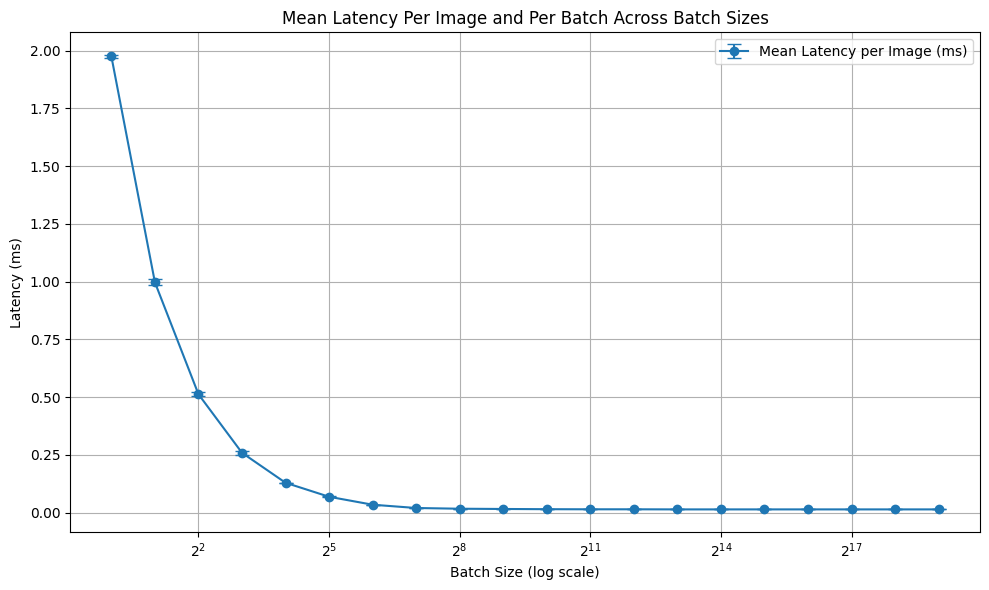

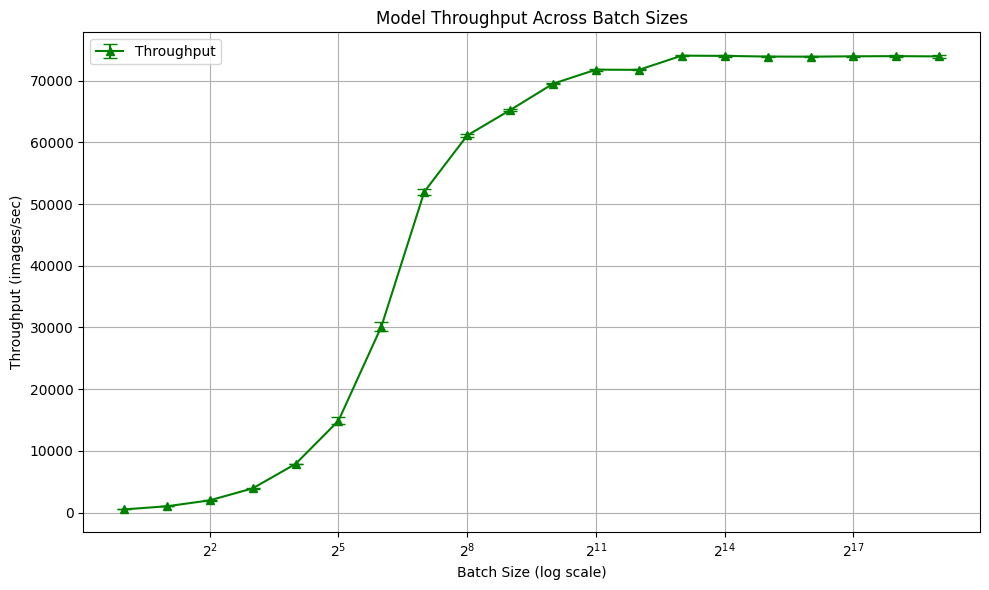

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data into a pandas DataFrame
csv_file = "latency_results_studen1_final.csv"  # Replace with your CSV file name
data = pd.read_csv(csv_file)

# Plot Mean Latency Per Image and Per Batch
plt.figure(figsize=(10, 6))

# Plot mean latency per image
plt.errorbar(
    data["Batch Size"],
    data["Mean Latency per Image (ms)"],
    yerr=data["Std Latency per Image (ms)"],
    fmt='o-',
    label="Mean Latency per Image (ms)",
    capsize=5
)

# Plot mean latency per batch
# plt.errorbar(
#     data["Batch Size"],
#     data["Mean Latency per Batch (ms)"],
#     yerr=data["Std Latency per Batch (ms)"],
#     fmt='s-',
#     label="Mean Latency per Batch (ms)",
#     capsize=5
# )

# Set log scale for x-axis
plt.xscale("log", base=2)

# Add labels, title, and legend
plt.xlabel("Batch Size (log scale)")
plt.ylabel("Latency (ms)")
plt.title("Mean Latency Per Image and Per Batch Across Batch Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()




# Plot Throughput with Error Bars
plt.figure(figsize=(10, 6))
plt.errorbar(data["Batch Size"], data["Mean Throughput (imgs/sec)"], yerr=data["Std Throughput (imgs/sec)"],
             fmt='^-', label="Throughput", capsize=5, color='green')
plt.xscale("log", base=2)  # Log scale for batch sizes
plt.xlabel("Batch Size (log scale)")
plt.ylabel("Throughput (images/sec)")
plt.title("Model Throughput Across Batch Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
